In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [242]:
# Read the data
df = pd.read_excel('../data/Health_Monitoring_System_Data.xlsx', sheet_name='Sheet1')
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [243]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Heart_Rate      2900 non-null   float64
 1   Blood_Pressure  3000 non-null   int64  
 2   Cholesterol     3000 non-null   int64  
 3   Blood_Sugar     2900 non-null   float64
 4   Risk_Level      3000 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 117.3+ KB


In [244]:
# Check the missing values
df.isnull().sum()

Heart_Rate        100
Blood_Pressure      0
Cholesterol         0
Blood_Sugar       100
Risk_Level          0
dtype: int64

In [245]:
 # print the rows with missing values
df[df.isnull().any(axis=1)]


,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
63,NaN,109,189,NaN,Low
79,NaN,99,178,NaN,High
82,NaN,97,175,NaN,Medium
147,NaN,114,231,NaN,Medium
163,NaN,110,208,NaN,Medium
...,...,...,...,...,...
2822,NaN,138,243,NaN,High
2835,NaN,135,218,NaN,Low
2872,NaN,134,150,NaN,High
2955,NaN,84,191,NaN,Medium


In [246]:
df_regression = df.dropna().drop(['Heart_Rate'], axis=1)
df_null = pd.get_dummies(df[df.isnull().any(axis=1)].drop(['Heart_Rate'], axis=1))

df_regression.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,138,234,82.0,Medium
1,85,210,109.0,Medium
2,120,158,137.0,High
3,118,155,111.0,Medium
4,83,184,88.0,Medium


In [247]:
df_null.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level_High,Risk_Level_Low,Risk_Level_Medium
63,109,189,NaN,0,1,0
79,99,178,NaN,1,0,0
82,97,175,NaN,0,0,1
147,114,231,NaN,0,0,1
163,110,208,NaN,0,0,1


In [248]:
# Split the data into train and test
X = pd.get_dummies(df_regression.drop(['Blood_Sugar'], axis=1))
y = df_regression['Blood_Sugar']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

In [249]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def find_best_k(X_train, y_train, X_test, y_test, k_range=(1, 40)):
    error_rate = []
    for i in range(k_range[0], k_range[1]):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.sqrt(mean_squared_error(y_test, pred_i)))

    plt.figure(figsize=(10, 6))
    plt.plot(range(k_range[0], k_range[1]), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('RMSE vs. K Value')
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.show()

    # print the best k
    best_k = error_rate.index(min(error_rate)) + 1
    print("Minimum RMSE:", min(error_rate), "at K =", best_k)
    
    return best_k


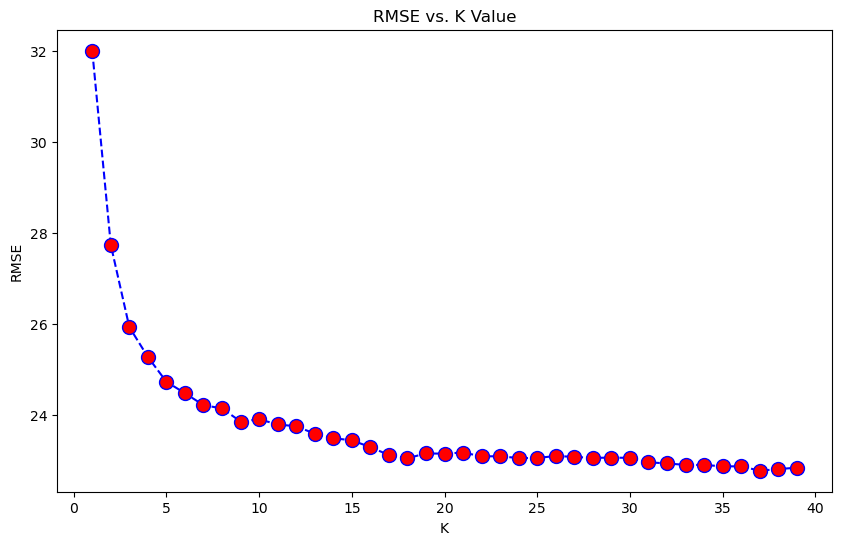

Minimum RMSE: 22.773747318187937 at K = 37


In [250]:
best_k_sug = find_best_k(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [251]:
# train the model with the best k
knn = KNeighborsRegressor(n_neighbors=best_k_sug)
knn.fit(X_train_reg,y_train_reg)
pred = knn.predict(X_test_reg)
print('RMSE:',np.sqrt(mean_squared_error(y_test_reg,pred)))

# predict the missing values
df_null['Blood_Sugar'] = np.round(knn.predict(df_null.drop(['Blood_Sugar'], axis=1)))
df_null.head()

RMSE: 22.773747318187937


,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level_High,Risk_Level_Low,Risk_Level_Medium
63,109,189,108.0,0,1,0
79,99,178,113.0,1,0,0
82,97,175,115.0,0,0,1
147,114,231,116.0,0,0,1
163,110,208,112.0,0,0,1


In [252]:
# fill the missing values in the original dataframe
df['Blood_Sugar'].fillna(df_null['Blood_Sugar'], inplace=True)
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [253]:
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [254]:
# now get the missing values for heart rate
df_hr = df.dropna()
df_hr.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [255]:
# get the rows where heart rate is missing
df_null_hr = df[df.isnull().any(axis=1)].drop(['Heart_Rate'], axis=1)
df_null_hr.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
63,109,189,108.0,Low
79,99,178,113.0,High
82,97,175,115.0,Medium
147,114,231,116.0,Medium
163,110,208,112.0,Medium


In [256]:
# split the data into train and test
X_hr = pd.get_dummies(df_hr.drop(['Heart_Rate'], axis=1))
y_hr = df_hr['Heart_Rate']

X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X_hr, y_hr, test_size=0.2, random_state=42)

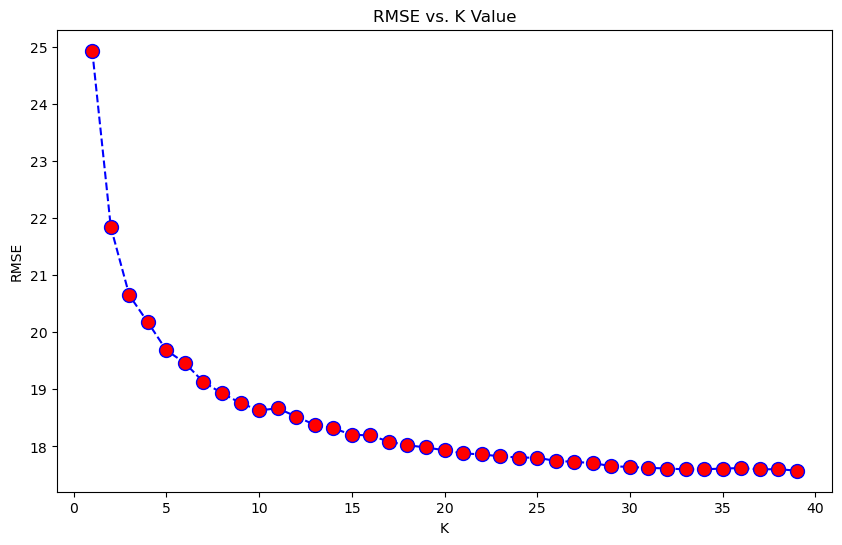

Minimum RMSE: 17.57549608840766 at K = 39
RMSE: 17.57549608840766


,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level,Heart_Rate
63,109,189,108.0,Low,76.0
79,99,178,113.0,High,81.0
82,97,175,115.0,Medium,80.0
147,114,231,116.0,Medium,79.0
163,110,208,112.0,Medium,78.0


In [257]:
# find the best k
best_k_hr = find_best_k(X_train_hr, y_train_hr, X_test_hr, y_test_hr)

# train the model with the best k
knn_hr = KNeighborsRegressor(n_neighbors=best_k_hr)
knn_hr.fit(X_train_hr,y_train_hr)
pred_hr = knn_hr.predict(X_test_hr)
print('RMSE:',np.sqrt(mean_squared_error(y_test_hr,pred_hr)))

# predict the missing values
X_null_hr = pd.get_dummies(df_null_hr)
df_null_hr['Heart_Rate'] = np.round(knn_hr.predict(X_null_hr))
df_null_hr.head()


In [258]:
# fill the missing values in the original dataframe
df['Heart_Rate'].fillna(df_null_hr['Heart_Rate'], inplace=True)
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [259]:
df.isnull().sum()

Heart_Rate        0
Blood_Pressure    0
Cholesterol       0
Blood_Sugar       0
Risk_Level        0
dtype: int64

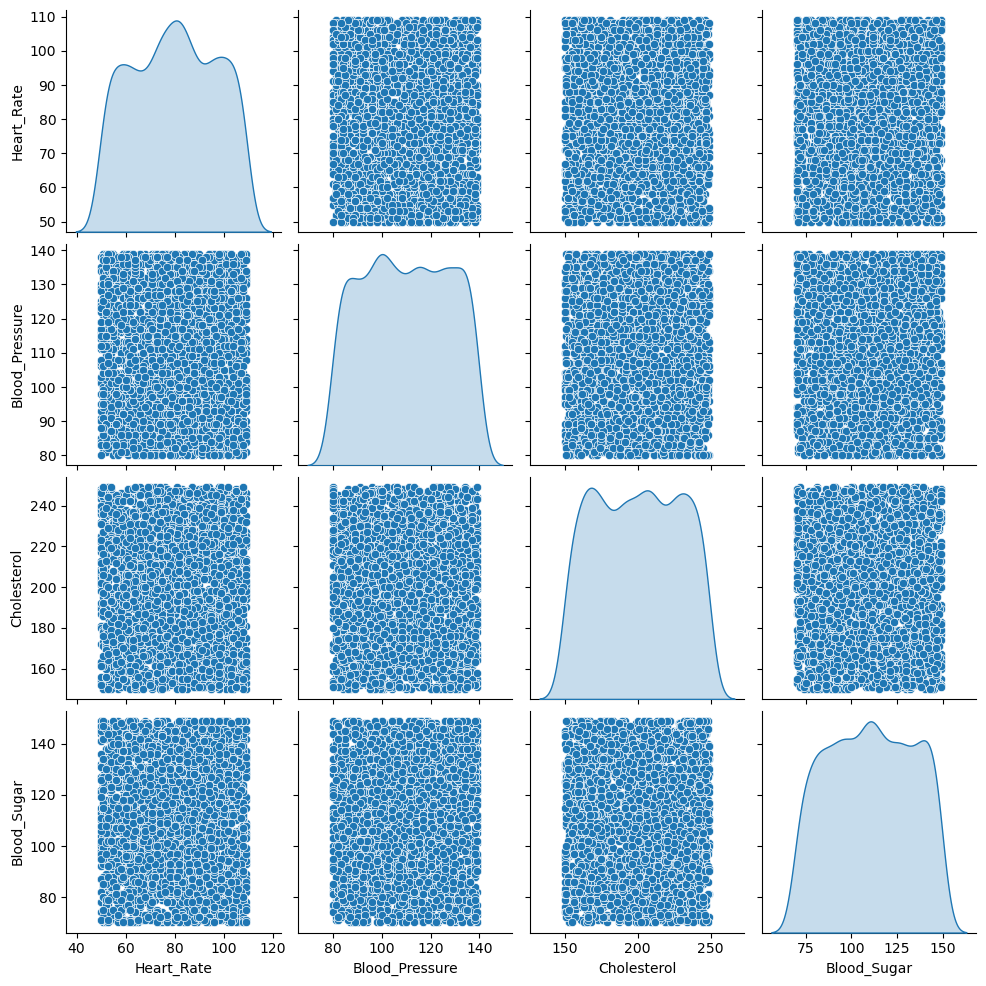

In [260]:
# pairplot
import seaborn as sns
sns.pairplot(df, diag_kind = "kde")

In [261]:
# Risk_Level into numerical values
df['Risk_Level'] = df['Risk_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,1
1,101.0,85,210,109.0,1
2,78.0,120,158,137.0,2
3,64.0,118,155,111.0,1
4,92.0,83,184,88.0,1


In [300]:
X = df.drop(['Risk_Level'], axis=1)
y = df['Risk_Level']

In [302]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.values

In [303]:
X

array([[ 0.48128959,  1.62205134,  1.19826159, -1.24259465],
       [ 1.24564573, -1.42562028,  0.36092637, -0.05873967],
       [-0.10667668,  0.58699306, -1.45329994,  1.16896179],
       ...,
       [-1.28260921,  0.47198658, -0.51129782,  0.81818995],
       [-1.34140584, -0.8505879 , -0.61596472,  1.30050123],
       [ 0.12850983,  0.12696715, -0.12751918, -0.76028336]])

In [275]:
# Tpot
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3616666666666667

Generation 2 - Current best internal CV score: 0.3616666666666667

Generation 3 - Current best internal CV score: 0.36291666666666667

Generation 4 - Current best internal CV score: 0.36291666666666667

Generation 5 - Current best internal CV score: 0.36291666666666667

Best pipeline: XGBClassifier(FastICA(input_matrix, tol=0.05), learning_rate=0.001, max_depth=4, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.6500000000000001, verbosity=0)
0.3333333333333333


In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [347]:
def get_best_score_based_on_random_state(model, X, y, random_state_range=(0, 100)):
    best_score = 0
    best_random_state = 0
    for i in range(random_state_range[0], random_state_range[1]):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = accuracy_score(y_test, pred)
        if score > best_score:
            best_score = score
            best_random_state = i
    print("Best score:", best_score, "at random state:", best_random_state)
    return best_random_state

In [348]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
get_best_score_based_on_random_state(lr, X, y)


Best score: 0.4066666666666667 at random state: 56


56

In [349]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
get_best_score_based_on_random_state(clf, X, y)

Accuracy: 0.33
Best score: 0.41333333333333333 at random state: 32


32

In [350]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
get_best_score_based_on_random_state(gnb, X, y)

Accuracy: 0.30666666666666664
Best score: 0.4 at random state: 56


56

In [351]:
from sklearn import svm

svmC = svm.SVC()
svmC.fit(X_train, y_train)
y_pred = svmC.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
get_best_score_based_on_random_state(svmC, X, y)

Accuracy: 0.37333333333333335
Best score: 0.41333333333333333 at random state: 17


17

In [352]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
get_best_score_based_on_random_state(rfc, X, y)

Accuracy: 0.3333333333333333
Best score: 0.41 at random state: 38


38

In [353]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
get_best_score_based_on_random_state(xgb, X, y)

Accuracy: 0.39
Best score: 0.4033333333333333 at random state: 6


6